In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

d2l.init_Seed()
device = d2l.get_device()

GPU ready!


In [2]:
config = {
    "n_train": 20,
    "n_test": 100,
    "n": 200,
    "batch_size": 5,
    "n_epochs": 100,
    "weight_decay": 3,
    "optimizer": "SGD",
#     "optimizer": "Adam",
    # "optimizer": "Adagrad",
    # "optimizer": "Adadelta",
    "optim_hparas": {
        'lr': 0.003,         # for SGD and Adam
#         'momentum': 0.9,
#         'nesterov':True
    },
    'lr_scheduler': 'StepLR',
    'lr_sched_hparas':{
        'step_size': 50,
        'gamma': 0.97
    }
}

In [3]:
true_w = torch.ones((config['n'])) * 0.01
true_b = 0.05
X, y = d2l.synthetic_data(true_w, true_b, config['n_train'] + config['n_test'])

In [4]:
tr_set = d2l.prep_dataloader(X[:config['n_train']], y[:config['n_train']], 'train', config['batch_size'])
te_set = d2l.prep_dataloader(X[config['n_train']:], y[config['n_train']:], 'test', config['batch_size'])

In [5]:
class Linreg(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        
        self.net = nn.Sequential(nn.Linear(n_features, 1))
        
        self.net[0].weight.data.normal_(0, 1)
        # self.net[0].weight.data.fill_(-1.5)

        # self.net[0].bias.data.fill_(torch.rand(1,).item())
        self.net[0].bias.data.fill_(0)


    def forward(self, X):
        return self.net(X).squeeze(1)


min_loss: 0.22662879526615143
tensor(0.4074, device='cuda:0', grad_fn=<CopyBackwards>)


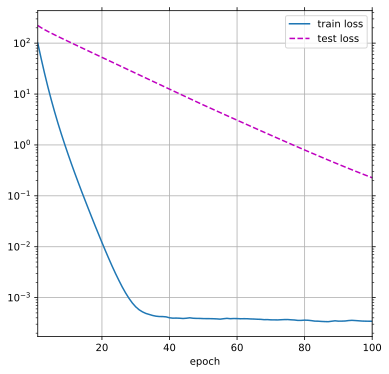

In [6]:
model = Linreg(config["n"]).to(device)
loss = nn.MSELoss(reduction='mean')
optimizer = getattr(torch.optim, config['optimizer'])(
    [
        {
            'params': model.net[0].weight,
            'weight_decay': config['weight_decay']
        },
        {
            'params': model.net[0].bias
        }
    ], 
    **config['optim_hparas'])

lr_scheduler = getattr(torch.optim.lr_scheduler, config["lr_scheduler"])(optimizer, **config["lr_sched_hparas"])

min_loss = d2l.train_reg(model, tr_set, te_set, loss, optimizer, lr_scheduler, device, config['n_epochs'])
print(f"min_loss: {min_loss}")
print(model.net[0].weight.norm())